# Racial Bias Analysis of COMPAS Scoring System 

This notebook focus on the analysis of racial bias of the recidivism scoring predicted by COMPAS. The COMPAS system scales the risk of recidivism from 1 to 10, 1 means low rick and 10 means high risk. 

To analyze the bias of their prediction result and comment the fairness of the system, we can set a threshold on the score and if the score is higher than the threshold, we consider the prediction is postive on recidivism. 

Based on the prediction and the actual recidivism, 4 metrics will be used for evaluation. 
- Accuracy: num_correct_prediction / num_prediction
- False positive rate (FPR) : num_predicted_recid_but_actual_nonrecid / num_actual_nonrecid
- Positive predictive value (PPV, same as precision) : num_predicted_recid_and_actual_recid / num_predicted_recid
- False omission rate (FOR) : num_predicted_nonrecid_but_actual_recid / num_predicted_non_recid

Accuracy measures the overall situation of the prediction, but could be influenced by unbiased-distributed data. FPR determines the error of unjustice, classifying an unrecidivated to a recidivator, which could be the most important metrics considering the rule of the judicial system. PPV measures the positively predicted outcomes from the scoring and threshold system. If PPV is high, the system could be considered to be more cautious on classifying a people as recidivator. If low, the system could be too radical, which also goes against the rule of judicial system.  On the other hand, FOR defines the negative prediction result of the system and it defines how many recidivator are ignored from the prediction of the system.

#### 0. Prepeocessing and Helper Functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

conn = sqlite3.connect('./data/compas.db')
c = conn.cursor()
people = pd.read_sql_query("SELECT id, race, decile_score, is_recid FROM people", conn)


In [2]:
people = people[people['is_recid'] != -1]
people = people[people['decile_score'] != -1]

In [3]:
people['decile_score'].value_counts()

1     2368
2     1478
3     1167
4     1130
5      982
6      941
7      862
9      761
8      758
10     580
Name: decile_score, dtype: int64

In [4]:
def prediction(threshold, df):
    return df['decile_score'].apply(lambda x: 1 if x >= threshold else 0)

def accuracy(df):
    return (df['is_recid'] == df['prediction']).sum() / df.shape[0]

def false_positive_rate(df):
    return ((df['prediction'] == 1) & (df['is_recid'] == 0)).sum() / ((df['is_recid'] == 0).sum())

def positive_predictive_value(df):
    return ((df['prediction'] == 1) & (df['is_recid'] == 1)).sum() / ((df['prediction'] == 1).sum())

def false_omission_rate(df):
    return ((df['prediction'] == 0) & (df['is_recid'] == 1)).sum() / ((df['prediction'] == 0).sum())

def num_false_positive(df):
    return ((df['prediction'] == 1) & (df['is_recid'] == 0)).sum()

def num_false_negative(df):
    return ((df['prediction'] == 0) & (df['is_recid'] == 1)).sum()

#### 1. Thresholding the prediction

We will first use the overall situation, which means races will not be sepreated and all the data will be included, to determine a proper threshold for further investigation. Based on the knowledge of the metrics, we will choose a threshold that with at most 20% of FPR, to ensure the justice, and a FOR as low as possible, to minimize the outcome of undiscovered recidivator.

Under such a principle, 7 would be the threshold. Since the choice of threshold only depend on 2 of the metrics, we can further check the rest of the 2 metrics, accuracy and PPV, to see if 7 is proper. From the point of accuracy, threshold 7 only drops for 1% comparing with the highest accuracy. From the perspective of PPV, threshold 7 decreases for 3% comparing with the highest PPV, hence we consider it is proper. 

   threshold metric     value
0          3    ACC  0.557087
1          3    FPR  0.570844
2          3    PPV  0.417630
3          3    FOR  0.182527
4          4    ACC  0.601614
5          4    FPR  0.457685
6          4    PPV  0.442468
7          4    FOR  0.207461
8          5    ACC  0.634805
9          5    FPR  0.355583
10         5    PPV  0.466626
11         5    FOR  0.231483
12         6    ACC  0.656752
13         6    FPR  0.272045
14         6    PPV  0.489236
15         6    FOR  0.251509
16         7    ACC  0.668450
17         7    FPR  0.199017
18         7    PPV  0.507599
19         7    FOR  0.272502
20         8    ACC  0.674617
21         8    FPR  0.135545
22         8    PPV  0.526918
23         8    FOR  0.290659
24         9    ACC  0.672803
25         9    FPR  0.085176
26         9    PPV  0.534676
27         9    FOR  0.308074


<AxesSubplot:xlabel='metric', ylabel='value'>

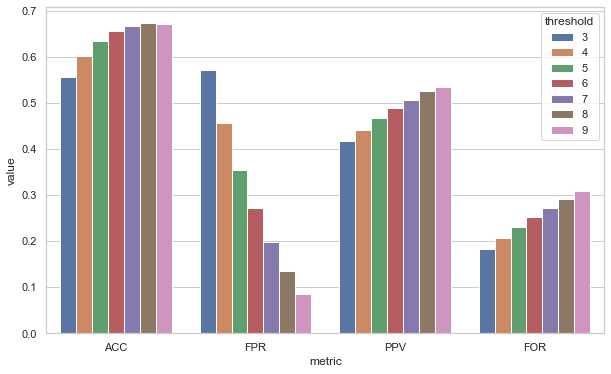

In [5]:
results = pd.DataFrame(columns=['threshold', 'metric', 'value'])

for i in range(3, 10):
    people['prediction'] = prediction(i, people)
    results = results.append({'threshold': i, 'metric': 'ACC', 'value': accuracy(people)}, ignore_index=True)
    results = results.append({'threshold': i, 'metric': 'FPR', 'value': false_positive_rate(people)}, ignore_index=True)
    results = results.append({'threshold': i, 'metric': 'PPV', 'value': positive_predictive_value(people)}, ignore_index=True)
    results = results.append({'threshold': i, 'metric': 'FOR', 'value': false_omission_rate(people)}, ignore_index=True)

print(results)
plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y = 'value', hue = 'threshold', data=results)


#### 2.1 Racial Bias Analysis

##### 2.1 Racial Bias Analysis on 4 metrics

In this section, we will evaluate the COMPAS scoring system on the same metrics (ACC, FPR, PPV, FOR), of different races. In COMPAS, people are classified into 6 different races (African-American, Caucasian, Hispanic, Asian, Native American, and other). 3 of the most popuplar races in the database, African-American, Caucasian and Hispanic, are selected since they have more than 1000 samples, which can make the result more stastistically significant. 

As we can see in the following figure, the metrics on African-American are worse than the other two, especially on FPR, which is considered the priority metric of the 4. On Accuracy, PPV and FOR, the Cacasian and Hispanic have a little advantages, but for FPR, they are 20% less than the Afrian-American. 

In [6]:
print(people['race'].value_counts())
print(people.groupby('race')['is_recid'].value_counts())

African-American    5498
Caucasian           3811
Hispanic            1009
Other                620
Asian                 53
Native American       36
Name: race, dtype: int64
race              is_recid
African-American  0           3324
                  1           2174
Asian             0             42
                  1             11
Caucasian         0           2723
                  1           1088
Hispanic          0            748
                  1            261
Native American   0             23
                  1             13
Other             0            466
                  1            154
Name: is_recid, dtype: int64


<AxesSubplot:xlabel='metric', ylabel='value'>

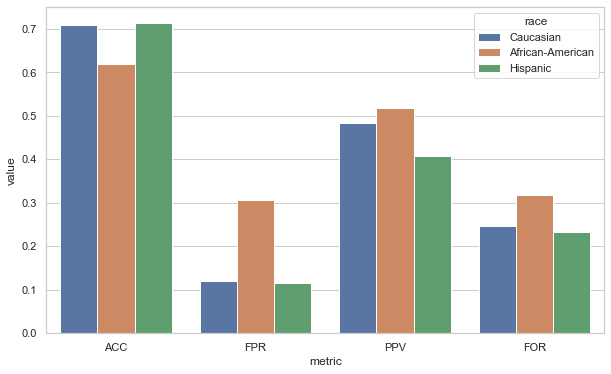

In [7]:
results = pd.DataFrame(columns=['race', 'metric', 'value'])

people['prediction'] = prediction(7, people)

for race in ['Caucasian', 'African-American', 'Hispanic']:
    results = results.append({'race': race, 'metric': 'ACC', 'value': accuracy(people[people['race']==race])}, ignore_index=True)
    results = results.append({'race': race, 'metric': 'FPR', 'value': false_positive_rate(people[people['race']==race])}, ignore_index=True)
    results = results.append({'race': race, 'metric': 'PPV', 'value': positive_predictive_value(people[people['race']==race])}, ignore_index=True)
    results = results.append({'race': race, 'metric': 'FOR', 'value': false_omission_rate(people[people['race']==race])}, ignore_index=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y = 'value', hue = 'race', data=results)

##### 2.2 Racial Bias Analysis on cost

Still, under the assumption that a high COMPAS score indicates a higher predictive probability of recidivism, 2 kinds of error the prediction could make, false positive and false negative. False positive represents those are treated unjusticed, wrongly judged as guilty, and false negative is the guilty that the system do not presents a high score. Now we fix the cost of a false negative as one, and let the cost of false positve change from 0.1 to 10, i.e., from a single case of harm of a false positve is 10% of the false negative to 10 times of it. 

As the harm of false positive increases, the average cost of all races are incresing, whereas the rate of increase of African-American is faster than the others. Therefore, if false positive have a higher harm in reality, the African-Americans becomes more disadvantaged. 

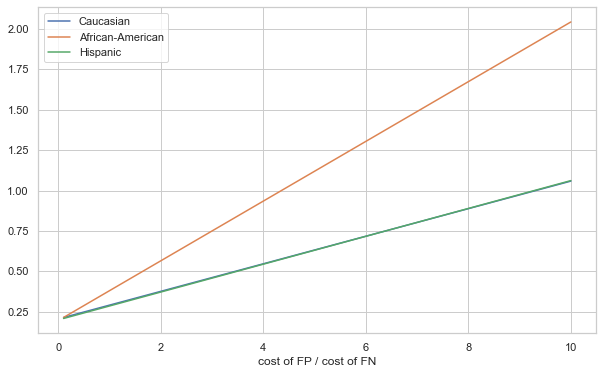

In [10]:
plt.figure(figsize=(10, 6))
rate_of_harm = np.linspace(0.1, 10, 1000)
for race in ['Caucasian', 'African-American', 'Hispanic']:
    num_fp = num_false_positive(people[people['race']==race])
    num_fn = num_false_negative(people[people['race']==race])
    cost = num_fp * rate_of_harm + num_fn
    cost = cost/people[people['race']==race].shape[0]
    plt.plot(rate_of_harm, cost, label = race)

plt.xlabel('cost of FP / cost of FN')
plt.legend()

#### 3. Solving the bias problem on machine learning algorithm with cost-sensitive learning

For a machine learning algorithm that predicts the probability of recidivism, cost-sensitive learning alters the penalty of a false positve and a false negative prediction, adapting the situation that type 1 and type 2 error have different level of harm. In recidivism scoring or prediction, a false positive do more harm to a false negative. Besides, from previous part we learn that as the relative harm of false positive gets higher that false negative, the average cost to African-American will have a larger gap than the other race group, which is a biased situation. Therefore, raising the cost of false positive could helps midigating the problem. 

We are starting by creating an prediction model that has equal cost for false positive and false negative. The model is trained using age, sex, felony or not, juveniel felony count, juveniel misdemeanor count, juveniel crime count and prior crime count as input features of a person. Then the testing result of African-Americans and other race groups are compared. 

The model will then alter the weight of cost to 0.8 for false positive and 0.2 for false negative, trained and tested with the same data samples. The resulting curves of costs under differnt ratio of false postive harm and false negative harm is presented and their differeces on the scale of curve are calculated. 

As a result, we can see in the following figure, the gap between different races will not gets larger and larger as before we use the cost sensitive learning technique. 

In [48]:
import sklearn
from sklearn.ensemble import RandomForestClassifier

In [49]:
train = pd.read_sql_query("SELECT * FROM people", conn)
train = train[['id','age', 'race', 'sex', 'c_charge_degree','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count', 'is_recid']].set_index('id')
train = train[train['is_recid'] != -1]
train['is_felony'] = train['c_charge_degree'].apply(lambda x: x in ['(F1)', '(F2)', '(F3)']).astype(int)
train['is_male'] = train['sex'].apply(lambda x: x=='Male').astype(int)
train['is_af'] = train['race'].apply(lambda x: x=='African-American').astype(int)
train.drop(['c_charge_degree', 'sex', 'race'], axis = 1, inplace = True)

In [50]:
train = train.sample(frac = 1, random_state = 0)
train = train[:int(train.shape[0]*0.5)]
test = train[int(train.shape[0]*0.5):]

In [51]:
test_af = test[test['is_af'] == 1]
test_other = test[test['is_af'] == 0]

In [63]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight={0:1, 1:1})
clf.fit(train[['age', 'is_male', 'is_felony','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count']], train['is_recid']) # race is not included as a input feature
pred_af = clf.predict(test_af[['age', 'is_male', 'is_felony','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count']])
pred_other = clf.predict(test_other[['age', 'is_male', 'is_felony','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count']])

In [64]:
def calculate_harm(pred, test, cost):
    num_fp = ((pred == 1) & (test['is_recid'] == 0)).sum()
    num_fn = ((pred == 0) & (test['is_recid'] == 1)).sum()
    return (num_fp * cost + num_fn)/test.shape[0]

In [66]:
cs_clf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight={0:.8, 1:.2})
cs_clf.fit(train[['age', 'is_male', 'is_felony','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count']], train['is_recid']) # race is not included as a input feature
cs_pred_af = cs_clf.predict(test_af[['age', 'is_male', 'is_felony','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count']])
cs_pred_other = cs_clf.predict(test_other[['age', 'is_male', 'is_felony','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count']])

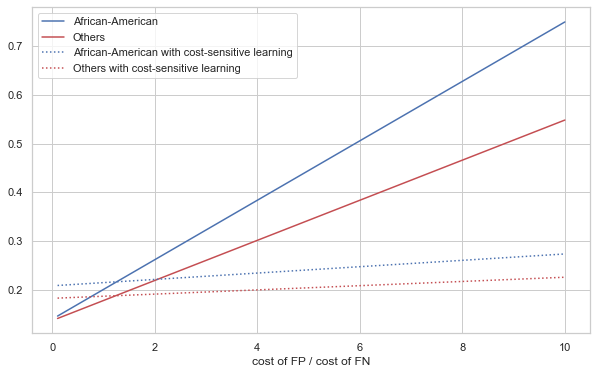

In [68]:
harm_af = calculate_harm(pred_af, test_af, np.linspace(0.1, 10, 1000))
harm_other = calculate_harm(pred_other, test_other, np.linspace(0.1, 10, 1000))
cs_harm_af = calculate_harm(cs_pred_af, test_af, np.linspace(0.1, 10, 1000))
cs_harm_other = calculate_harm(cs_pred_other, test_other, np.linspace(0.1, 10, 1000))

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0.1, 10, 1000), harm_af, 'b-',label = 'African-American')
plt.plot(np.linspace(0.1, 10, 1000), harm_other, 'r-', label = 'Others')
plt.plot(np.linspace(0.1, 10, 1000), cs_harm_af, 'b:', label = 'African-American with cost-sensitive learning')
plt.plot(np.linspace(0.1, 10, 1000), cs_harm_other,'r:',  label = 'Others with cost-sensitive learning')
plt.xlabel('cost of FP / cost of FN')
plt.legend()

In [69]:
scale_af = (harm_af[-1]-harm_af[0])/(10-0.1)
scale_other = (harm_other[-1]-harm_other[0])/(10-0.1)
cs_scale_af = (cs_harm_af[-1]-cs_harm_af[0])/(10-0.1)
cs_scale_other = (cs_harm_other[-1]-cs_harm_other[0])/(10-0.1)

print(scale_af, scale_other, cs_scale_af, cs_scale_other)

0.061046511627906974 0.041184971098265896 0.006540697674418604 0.004335260115606938


In [70]:
(scale_af - scale_other)/(cs_scale_af - cs_scale_other)

9.005714285714292